In [3]:
import pandas as pd
import numpy as np
import pickle as pkl
from fuzzywuzzy import process, fuzz
from matplotlib import pyplot as plt
import matplotlib
import seaborn as sns
import re
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
%matplotlib inline
matplotlib.rcParams['font.family'] = 'Arial'

In [84]:
with open("../data/pp_1000_models.pkl", 'rb') as picklefile:
    models = pkl.load(picklefile)

In [85]:
with open("../data/pp_1000_models_scores.pkl", 'rb') as picklefile:
    scores = pkl.load(picklefile)

In [3]:
models[1]['l2'].best_estimator_.named_steps['standardscaler'].var_

array([1.02154334e-01, 7.96984725e-02, 2.20956159e-01, 8.04570659e+02,
       2.49950407e-01, 2.32096806e-01, 3.26601865e-02, 5.31640548e-02,
       1.90628843e-01, 1.16929181e-01, 1.02154334e-01, 7.52365404e+00,
       9.22254672e+08])

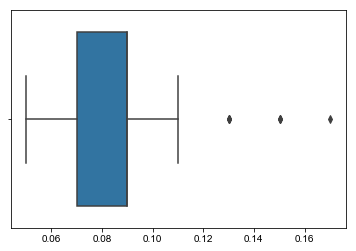

In [6]:
CC = []
l_test = []
l_diff = []
for x in range(100):
    CC.append(models[x]['l2'].best_estimator_.named_steps['logisticregression'].C)
    l_test.append(scores[x]['l2'][1])
    l_diff.append(scores[x]['l2'][1]-scores[x]['l2'][0])
    
sns.boxplot(CC)

In [90]:
uni_public = []
acceptance_rate = []
male = []
caucasian = []
african_american = []
latino = []
asian = []
chi_school = []
chi_home = []
financial_aid = []
median_income = []
private_hs = []
chipub_hs = []


for x in range(1000):
    chipub_hs.append(models[x]['l2'].best_estimator_.named_steps['logisticregression'].coef_[0][0])
    private_hs.append(models[x]['l2'].best_estimator_.named_steps['logisticregression'].coef_[0][1])
    uni_public.append(models[x]['l2'].best_estimator_.named_steps['logisticregression'].coef_[0][2])
    acceptance_rate.append(models[x]['l2'].best_estimator_.named_steps['logisticregression'].coef_[0][3])
    male.append(models[x]['l2'].best_estimator_.named_steps['logisticregression'].coef_[0][4])
    caucasian.append(models[x]['l2'].best_estimator_.named_steps['logisticregression'].coef_[0][5])
    african_american.append(models[x]['l2'].best_estimator_.named_steps['logisticregression'].coef_[0][6])
    latino.append(models[x]['l2'].best_estimator_.named_steps['logisticregression'].coef_[0][7])
    asian.append(models[x]['l2'].best_estimator_.named_steps['logisticregression'].coef_[0][8])
    chi_school.append(models[x]['l2'].best_estimator_.named_steps['logisticregression'].coef_[0][9])
    chi_home.append(models[x]['l2'].best_estimator_.named_steps['logisticregression'].coef_[0][10])
    financial_aid.append(models[x]['l2'].best_estimator_.named_steps['logisticregression'].coef_[0][11])
    median_income.append(models[x]['l2'].best_estimator_.named_steps['logisticregression'].coef_[0][12])
    
    
coefficients = pd.DataFrame({'Public University' : uni_public,
                            'Private University' : np.multiply(-1,uni_public),
                            'University Acceptance Rate' : acceptance_rate, 
                            'City of Chicago - School' : chi_school,
                            'Suburban Chicago - School' : np.multiply(-1,chi_school),
                            'School outside City of Chicago' : np.multiply(-1,chi_school),
                            'City of Chicago - Home' : chi_home,
                            'Home outside City of Chicago' : np.multiply(-1,chi_home),
                            'CYSO Financial Aid' : financial_aid,
                            'Home Median Income' : median_income,
                            'Male' : male,
                            'Female' : np.multiply(-1,male),
                            'African American' : african_american,
                            'Caucasian' :  caucasian,
                            'Latinx' : latino,
                            'Asian' : asian,
                            'Public HS' : np.multiply(-1,private_hs),
                            'Private HS' : private_hs,
                            'Chicago Public School' : chipub_hs,
                            'Suburban Public School' : np.multiply(-1,chipub_hs)
                            })   
    
    
coefficients.to_csv('../data/model_coefficients.csv')
    
    
    

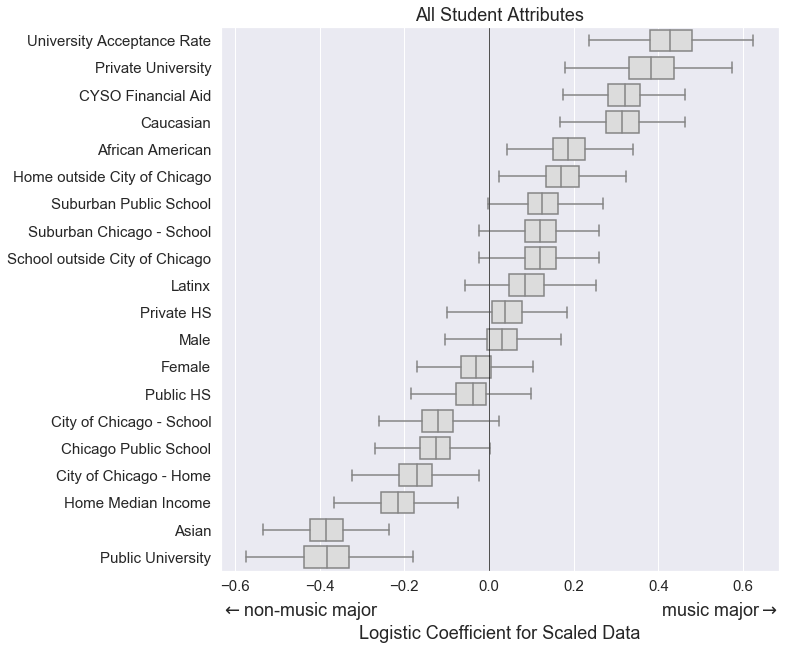

In [97]:
'''
boxplots
'''

#sns.set(rc={'figure.figsize':(10,5)})
coefficients_plot = coefficients.mean().values
coefficients_std = coefficients.std().values
features_plot = coefficients.columns
coefficients_inds = coefficients_plot.argsort()
sorted_coefficients = coefficients_plot[coefficients_inds[::-1]]
sorted_std = coefficients_std[coefficients_inds[::-1]]
sorted_features = features_plot[coefficients_inds[::-1]]
plot_colors = ['gainsboro','gainsboro','firebrick','firebrick',
               'firebrick','firebrick','gainsboro','darkgrey',
               'darkgrey','darkgrey','darkgrey','darkgrey',
               'firebrick','royalblue']
plt.subplots(figsize=(10,10))
plt.axvline(x=0,c='k',linewidth=0.5)
ax = sns.boxplot(data=coefficients,
                orient = 'h',
                order = sorted_features,
                showfliers=False,
                color='gainsboro')#,
                #whis=0)
plt.axvline(x=0,c='k',linewidth=0.5)
#plt.style.use('ggplot')
space_string = '                                                         '
ax.set_xlabel(r'$\leftarrow$'+'non-music major'+space_string+'music major'+r'$\rightarrow$'+'\nLogistic Coefficient for Scaled Data',fontsize=18)
#ax.set_xlabel('Logistic Coefficient for \n Scaled Data')
#ax.set_ylabel('Student Attribute',fontsize=18)
plt.title('All Student Attributes',fontsize=18)
plt.tick_params(labelsize=15)
#ax.get_xaxis().set_ticks([])
fig = ax.get_figure()
fig.savefig('../plots/allfactors_withwhisker_highlights.pdf',bbox_inches='tight')

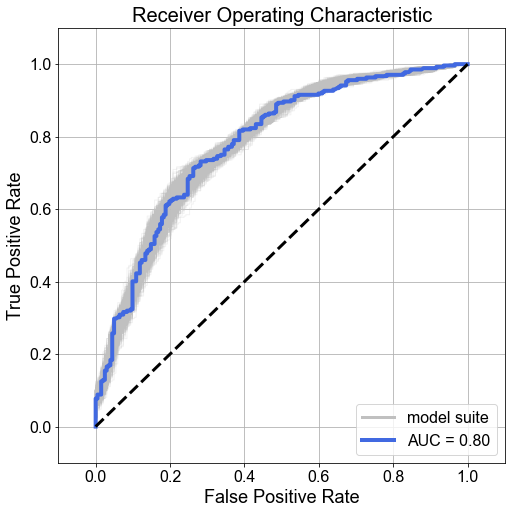

In [14]:
'''
ROC Plot
'''

df = pd.read_csv('../data/fitting_data.csv')
df.drop(['Unnamed: 0'],axis=1,inplace=True)
df = df.fillna(0)
y = df.pop('music').values
stratification_columns = df.pop('stratification_column').values
X = df.values

logit_num = 6

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42,stratify=X[:,9])

datapointers = {
    'l1' : 'logistic',
    'l2' : 'logistic',
    'rf' : 'not_logistic',
    'gb' : 'not_logistic',
    'linsvc' : 'not logistic',
    'rbfsvc' : 'not logistic'
}


# Initialize figure
fig = plt.figure(figsize=(8,8))
plt.title('Receiver Operating Characteristic',fontsize=20)

name = 'l2'

for x in range(1000):
    if datapointers[name] == 'logistic':
        pred = models[x][name].predict_proba(X[:,logit_num:])
    else:
        pred = models[x][name].predict_proba(X)
    pred = [p[1] for p in pred]
    fpr, tpr, thresholds = roc_curve(y, pred)

    
    # Plot ROC curve
    plt.plot(fpr, tpr, c='silver',linewidth=1,alpha=0.2)
    

pred = models[52][name].predict_proba(X[:,logit_num:])
pred = [p[1] for p in pred]
fpr, tpr, thresholds = roc_curve(y, pred)
plt.plot(fpr, tpr, label='model suite', c='silver',linewidth=3)    

plotnum = 55
pred = models[plotnum][name].predict_proba(X[:,logit_num:])
pred = [p[1] for p in pred]
fpr, tpr, thresholds = roc_curve(y, pred)
plt.plot(fpr, tpr, label = 'AUC = {:0.2f}'.format(scores[plotnum]['l2'][1]), c='royalblue',linewidth=4)

# Diagonal 45 degree line
plt.plot([0,1],[0,1],'k--',linewidth=3)
plt.legend(loc='lower right',fontsize=16)

# Axes limits and labels
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.ylabel('True Positive Rate',fontsize=18)
plt.xlabel('False Positive Rate',fontsize=18)
plt.tick_params(labelsize=16)
plt.grid(True)
plt.show()
fig.savefig('../plots/ROC_pp.pdf',bbox_inches='tight')
fig.savefig('../plots/ROC_pp.png',bbox_inches='tight')

In [19]:
with open("../data/all_models.pkl", 'rb') as picklefile:
    models = pkl.load(picklefile)
with open("../data/all_models_scores.pkl", 'rb') as picklefile:
    scores = pkl.load(picklefile)

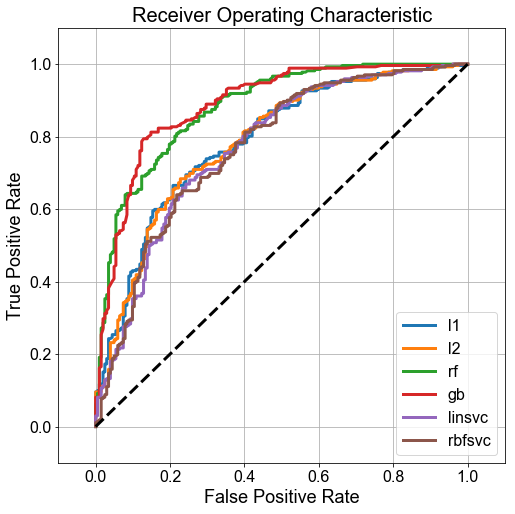

In [18]:
'''
ROC Plot - multimodel
'''

df = pd.read_csv('../data/fitting_data.csv')
df.drop(['Unnamed: 0'],axis=1,inplace=True)
df = df.fillna(0)
y = df.pop('music').values
stratification_columns = df.pop('stratification_column').values
X = df.values


logit_num = 6

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42,stratify=X[:,9])

datapointers = {
    'l1' : 'logistic',
    'l2' : 'logistic',
    'rf' : 'not_logistic',
    'gb' : 'not_logistic',
    'linsvc' : 'not logistic',
    'rbfsvc' : 'not logistic'
}

long_names = {
    'l1' : 'logistic regression - L1 norm',
    'l1' : 'logistic regression - L1 norm',
    'rf' : 'random forest',
    'gb' : 'gradient boost',
    'linsvc' : 'SVC - linear kernel',
    'rbfsvc' : 'SVC - rbf kernel'
}


# Initialize figure
fig = plt.figure(figsize=(8,8))
plt.title('Receiver Operating Characteristic',fontsize=20)

model_names = ['l1','l2','rf','gb','linsvc','rbfsvc']

for name in model_names:
    if datapointers[name] == 'logistic':
        pred = models[0][name].predict_proba(X[:,logit_num:])
    else:
        pred = models[0][name].predict_proba(X)
    pred = [p[1] for p in pred]
    fpr, tpr, thresholds = roc_curve(y, pred)

    
    # Plot ROC curve
    plt.plot(fpr, tpr,linewidth=3,label=name)
    

# pred = models[52][name].predict_proba(X[:,logit_num:])
# pred = [p[1] for p in pred]
# fpr, tpr, thresholds = roc_curve(y, pred)
# plt.plot(fpr, tpr, label='model suite', c='silver',linewidth=3)    

# plotnum = 55
# pred = models[plotnum][name].predict_proba(X[:,logit_num:])
# pred = [p[1] for p in pred]
# fpr, tpr, thresholds = roc_curve(y, pred)
# plt.plot(fpr, tpr, label = 'AUC = {:0.2f}'.format(scores[plotnum]['l2'][1]), c='royalblue',linewidth=4)

# Diagonal 45 degree line
plt.plot([0,1],[0,1],'k--',linewidth=3)
plt.legend(loc='lower right',fontsize=16)

# Axes limits and labels
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.ylabel('True Positive Rate',fontsize=18)
plt.xlabel('False Positive Rate',fontsize=18)
plt.tick_params(labelsize=16)
plt.grid(True)
plt.show()
fig.savefig('../plots/ROC_all.pdf',bbox_inches='tight')
fig.savefig('../plots/ROC_all.png',bbox_inches='tight')

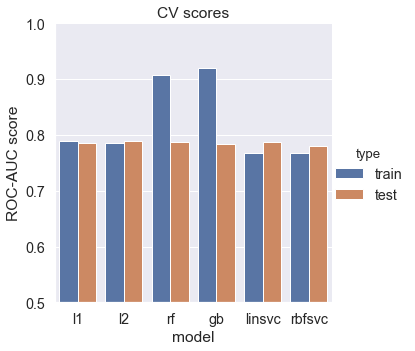

In [83]:
long_names = {
    'l1' : 'logistic regression - L1 norm',
    'l1' : 'logistic regression - L1 norm',
    'rf' : 'random forest',
    'gb' : 'gradient boost',
    'linsvc' : 'SVC - linear kernel',
    'rbfsvc' : 'SVC - rbf kernel'
}

model_names = ['l1','l2','rf','gb','linsvc','rbfsvc']

l_train = []
l_test = []
for names in model_names:
    l_train.append(scores[0][names][0])
    l_test.append(scores[0][names][1])
    
df = pd.DataFrame(scores[0])
df['type']=['train','test']
df = pd.melt(df, id_vars="type", var_name="model", value_name="ROC-AUC score")
#sns.set(font_scale=1.3)
ax = sns.catplot(x='model', y='ROC-AUC score', hue='type', data=df, kind='bar')
ax.set(ylim=(0.5, 1.0))
ax.set(title='CV scores')
#fig = ax.get_figure()
ax.savefig('../plots/multimodel_scores.pdf',bbox_inches='tight')

In [51]:
df

,type,model,ROC-AUC score
0,train,l1,0.789326
1,test,l1,0.785886
2,train,l2,0.785273
3,test,l2,0.789790
4,train,rf,0.907322
5,test,rf,0.788288
6,train,gb,0.919900
7,test,gb,0.783934
8,train,linsvc,0.767098
9,test,linsvc,0.786787


In [49]:
df

,type,model,ROC-AUC score
0,train,l1,0.789326
1,test,l1,0.785886
2,train,l2,0.785273
3,test,l2,0.789790
4,train,rf,0.907322
5,test,rf,0.788288
6,train,gb,0.919900
7,test,gb,0.783934
8,train,linsvc,0.767098
9,test,linsvc,0.786787


In [47]:
df

,l1,l2,rf,gb,linsvc,rbfsvc,type
0,0.789326,0.785273,0.907322,0.919900,0.767098,0.767194,train
1,0.785886,0.789790,0.788288,0.783934,0.786787,0.781081,test
